# Preliminaries and Retweet Removal

### Things to achieve in this notebook

- Open the data and get it in a form you can use           
- Plot a time series to check for down days etc.
- Count tweets in different languages
- Sentiment analysis
- Retweet filter
    - Do I want rid of retweets?
    - They kinda show this is effecting my imma pass this on/I agree with this

In [1]:
## Import libraries

import matplotlib.pyplot as plt                               # Used for plotting data
from collections import Counter                               # This is used to count occurances of values
import pandas as pd                                           # Used for cleanly displaying data
import numpy as np                                            # Collection of mathematical functions
import tarfile                                                # Used for extracting files
import json                                                   # Processing individual JSON files uses this
import csv                                                    # This was used to create and read csvs
import string
import pickle
import os                                                     # This helped locate and delete json files
import re
import random
from ast import literal_eval                                  # Used to convert strings to dict
from datetime import datetime                                 # This processes different date formats
from pandas.plotting import register_matplotlib_converters    # This had to be registered to allow for timeseries plots
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from emoji import demojize
from langdetect import detect
from multiprocessing import Process
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import cartopy.io.img_tiles as cimgt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import  confusion_matrix
register_matplotlib_converters()
pd.set_option('display.max_rows', 10)                         # Setting displayed panda length

## Open Data

In [7]:
%%time

def reducedinfo(json):                                                             # This isn't in loop for ease of reading
    '''
    Simple function takes json input and extracts the desired data.
    '''
    reducedinfo = {
        'timestamp_ms': json['timestamp_ms'],      
        'geo': json['geo'],     
        'screen_name': json['user']['screen_name'],
        'id': int(json['user']['id_str']),
        'text': json['text']
    }
    return reducedinfo

Wall time: 0 ns


In [9]:
File_Locations = 'C:/Users/beckr/Documents/Uni_Work/Masters/Advanced_Project/Data/tweets/'

if os.path.exists('AllHeatCSV.csv'):                                                # Prevents overlap of files
    os.remove('AllHeatCSV.csv')

with open('AllHeatCSV.csv', "a+", encoding='utf-8', newline='') as csvfile:         # Loop for all files in File_Locations
    writer = csv.writer(csvfile)

    for filename in os.listdir(File_Locations):                                     # Iterates through the files to extract
        with open((File_Locations + filename), mode='r', encoding='utf-8') as current: 
            
            for line in current:
                
                tweet = json.loads(line)
                reducedtweet = reducedinfo(tweet)                                   # Reduces the tweet
                writer.writerow(reducedtweet.values())


In [12]:
# For ease of indexing

timestamp = 0
geo = 1
sn = 2
ID = 3
text = 4
sentiment = 5

## Tweet Counting

In [10]:
# Count tweets

NumTweets = 0                                                      # Loop simply runs through each row (tweet) and counts
with open('AllHeatCSV.csv', 'r', encoding='utf-8') as current:
    reader = csv.reader(current)
    for line in reader:
        NumTweets += 1
        
print('Total number of tweets: ', NumTweets)

Total number of tweets:  5893778


In [13]:
tweetcount = Counter()                                              # Initialise counter
with open('AllHeatCSV.csv','r', encoding='utf-8') as csvfile:       # Run through lines of csv
    read = csv.reader(csvfile)
    for line in read:
        ts = int(line[timestamp])/1000                              # Convert timestamps to ms                     
        Date = datetime.utcfromtimestamp(ts).date()                 # Turn ts into date
        tweetcount[Date] +=1

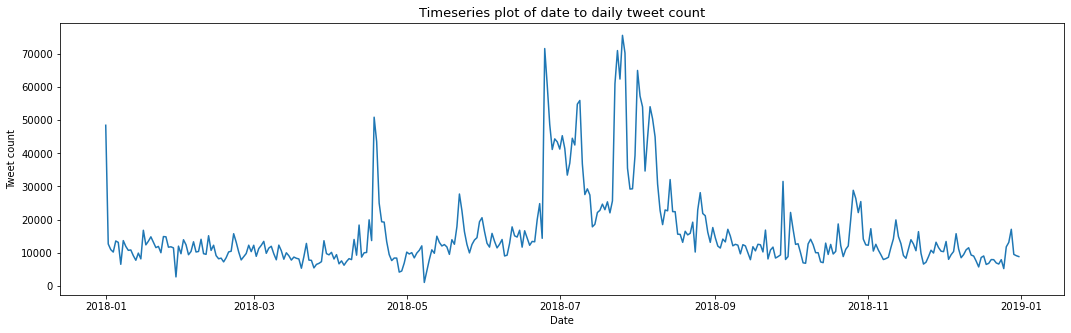

In [14]:
lists = sorted(tweetcount.items())                                  # Sorting and seperating the data
day, quant = zip(*lists)

plt.figure(figsize = [18,5])
plt.plot(day,quant)
plt.title('Timeseries plot of date to daily tweet count', size = 13)
plt.xlabel('Date')
plt.ylabel('Tweet count')
plt.show()

## Language Analysis

In [15]:
# Count how many undifined tweets are english language
countEng = 0

if os.path.exists('AllHeatEngCSV.csv'):                                                # Prevents overlap of files
    os.remove('HeatEngCSV.csv')

with open('AllHeatEngCSV.csv', "a+", encoding='utf-8', newline='') as csvfile:         # Loop for all files in File_Locations
    writer = csv.writer(csvfile)

    with open('AllHeatCSV.csv','r', encoding='utf-8') as csvfile:       # Run through lines of csv
        read = csv.reader(csvfile)
        for line in read:
                             
            try: dt = detect(demojize(line[text]))
            except:
                continue
            if dt == 'en':
                writer.writerow(line)
                countEng = countEng + 1

print(countEng)

5646575


## Sentiment Analysis

In [17]:
analyzer = SentimentIntensityAnalyzer()

In [18]:
if os.path.exists('AllHeatSentCSV.csv'):                                                # Prevents overlap of files
    os.remove('AllHeatSentCSV.csv')

with open('AllHeatSentCSV.csv', "a+", encoding='utf-8', newline='') as csvfile:         # Loop for all files in File_Locations
    writer = csv.writer(csvfile)

    with open('AllHeatEngCSV.csv','r', encoding='utf-8') as csvfile:       # Run through lines of csv
        read = csv.reader(csvfile)
        for line in read:
            if len(line) == 5:  # Ensure all fields have entries
        
                vs = analyzer.polarity_scores(line[text])
                sent = vs['compound']

                newline = line + [sent]

                writer.writerow(newline)

In [19]:
tweetcount = Counter()                                              # Initialise counter
with open('AllHeatSentCSV.csv','r', encoding='utf-8') as csvfile:       # Run through lines of csv
    read = csv.reader(csvfile)
    for line in read:
        ts = int(line[timestamp])/1000                              # Convert timestamps to ms                     
        Date = datetime.utcfromtimestamp(ts).date()                 # Turn ts into date
        tweetcount[Date] +=1

In [49]:
df = pd.DataFrame.from_dict(tweetcount, orient = 'index')
df.index.name = 'Date'
df['sent'] = 0
i = 0
with open('AllHeatSentCSV.csv','r', encoding='utf-8') as csvfile:       # Run through lines of csv
    read = csv.reader(csvfile)
    for line in read:
        i = i+1
        ts = int(line[timestamp])/1000                              # Convert timestamps to ms                     
        Date = (datetime.utcfromtimestamp(ts).date())                 # Turn ts into date
        new = df.at[Date, 'sent'] + float(line[sentiment])
        df.loc[Date, 'sent'] = new
        
df['sent'] = df['sent']/df[0]

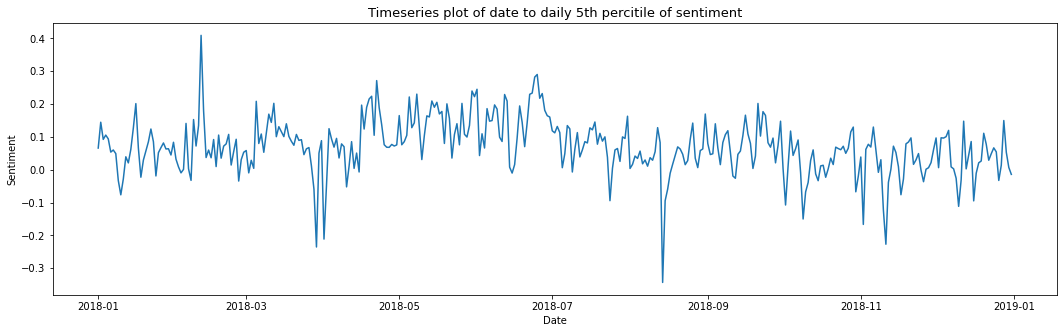

In [59]:
df = df.reset_index()
df = df.sort_values(by='Date')

plt.figure(figsize = [18,5])
plt.plot(df['Date'],df['sent'])
plt.title('Timeseries plot of date to daily 5th percitile of sentiment', size = 13)
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.show()

## Exclude Re-tweets

In [56]:
if os.path.exists('AllHeatRTCSV.csv'):                                                # Prevents overlap of files
    os.remove('AllHeatRTCSV.csv')

with open('AllHeatRTCSV.csv', "a+", encoding='utf-8', newline='') as csvfile:         # Loop for all files in File_Locations
    writer = csv.writer(csvfile)

    with open('AllHeatSentCSV.csv','r', encoding='utf-8') as csvfile:       # Run through lines of csv
        read = csv.reader(csvfile)

        for line in read:

            test_string = line[text]
            if test_string[0:2] != 'RT':
                writer.writerow(line)
                

In [60]:
# Count tweets

NumTweets = 0                                                      # Loop simply runs through each row (tweet) and counts
with open('AllHeatRTCSV.csv', 'r', encoding='utf-8') as current:
    reader = csv.reader(current)
    for line in reader:
        NumTweets += 1
        
print('Total number of tweets: ', NumTweets)

Total number of tweets:  1905665
